In [1]:
import torch
from hdn.lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from hdn.lib import histNoiseModel 
from hdn.lib.utils import plotProbabilityDistribution
from datasets import load_datasets_yml
from hdn.lib import histNoiseModel
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import logging as log

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

In [2]:

def plotProbabilityDistribution(ax1, ax2, signalBinIndex, histogram, gaussianMixtureNoiseModel, min_signal, max_signal, n_bin, device):
    """Plots probability distribution P(x|s) for a certain ground truth signal."""
    histBinSize = (max_signal - min_signal) / n_bin
    querySignal_numpy = (signalBinIndex / float(n_bin) * (max_signal - min_signal) + min_signal)
    querySignal_numpy += histBinSize / 2
    querySignal_torch = torch.from_numpy(np.array(querySignal_numpy)).float().to(device)
    
    queryObservations_numpy = np.arange(min_signal, max_signal, histBinSize)
    queryObservations_numpy += histBinSize / 2
    queryObservations = torch.from_numpy(queryObservations_numpy).float().to(device)
    pTorch = gaussianMixtureNoiseModel.likelihood(queryObservations, querySignal_torch)
    pNumpy = pTorch.cpu().detach().numpy()
    
    ax1.clear()
    ax2.clear()
    
    ax1.set_xlabel('Observation Bin')
    ax1.set_ylabel('Signal Bin')
    ax1.imshow(histogram**0.25, cmap='gray')
    ax1.axhline(y=signalBinIndex + 0.5, linewidth=5, color='blue', alpha=0.5)
    
    ax2.plot(queryObservations_numpy, histogram[signalBinIndex, :] / histBinSize, label='GT Hist: bin =' + str(signalBinIndex), color='blue', linewidth=2)
    ax2.plot(queryObservations_numpy, pNumpy, label='GMM : ' + ' signal = ' + str(np.round(querySignal_numpy, 2)), color='red', linewidth=2)
    ax2.set_xlabel('Observations (x) for signal s = ' + str(querySignal_numpy))
    ax2.set_ylabel('Probability Density')
    ax2.set_title("Probability Distribution P(x|s) at signal =" + str(querySignal_numpy))
    ax2.legend()

In [3]:
dataset_name = 'jump_cell_painting'
gt_name = 'n2v'
dataset_yml='datasets.yml'
channel = 0

device = torch.device("cuda:0")
dset = [d for d in load_datasets_yml(dataset_yml=dataset_yml) if d['name'] == dataset_name][0]

gt_path = f'predictions/{dataset_name}/{gt_name}.tiff'


log.info(f"Loading signals...")
observations = tifffile.imread(dset['path'])
signal = tifffile.imread(gt_path).squeeze()

assert (channel is None and signal.ndim == 3) or (channel is not None and signal.ndim == 4), "If image is multichannel then select a channel, otherwise set channel to None."

if channel is not None:
    print(f"Selecting channel {channel}")
    observations = observations[:, channel, ...]
    signal = signal[:, channel, ...]

datamin, datamax = observations.min(), observations.max()

out_folder = os.path.join('noise_models', dataset_name, gt_name, f'channel_{channel if channel is not None else 0}')
os.makedirs(out_folder, exist_ok=True)

min_signal=np.percentile(signal, 0)
max_signal=np.percentile(signal, 99)
bins=256
print(observations.shape, signal.shape)


INFO:root:Loading signals...


Selecting channel 0
(517, 540, 540) (517, 540, 540)


In [4]:
histogram = histNoiseModel.createHistogram(bins=bins, minVal=datamin, maxVal=datamax, observation=observations, signal=signal)
histogramFD = histogram[0]
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal, 
                                                      max_signal = max_signal, 
                                                      path=out_folder,
                                                      weight = None, 
                                                      n_gaussian = 3, 
                                                      n_coeff = 2, 
                                                      device = device, 
                                                      min_sigma = 50)

In [5]:
gaussianMixtureNoiseModel.train(signal,
                                observations,
                                batchSize = 250000,
                                n_epochs = 1000,
                                learning_rate = 0.1,
                                name = 'GMM',
                                lowerClip = 0.5,
                                upperClip = 99.5)

0 2.8790066242218018
100 2.8774938583374023
200 2.877492904663086
300 2.877514600753784
400 2.8775055408477783
500 2.8774919509887695
600 2.877504587173462
700 2.877516031265259
800 2.8774890899658203
900 2.877488136291504

The trained parameters (GMM) is saved at location: noise_models/jump_cell_painting/n2v/channel_0


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


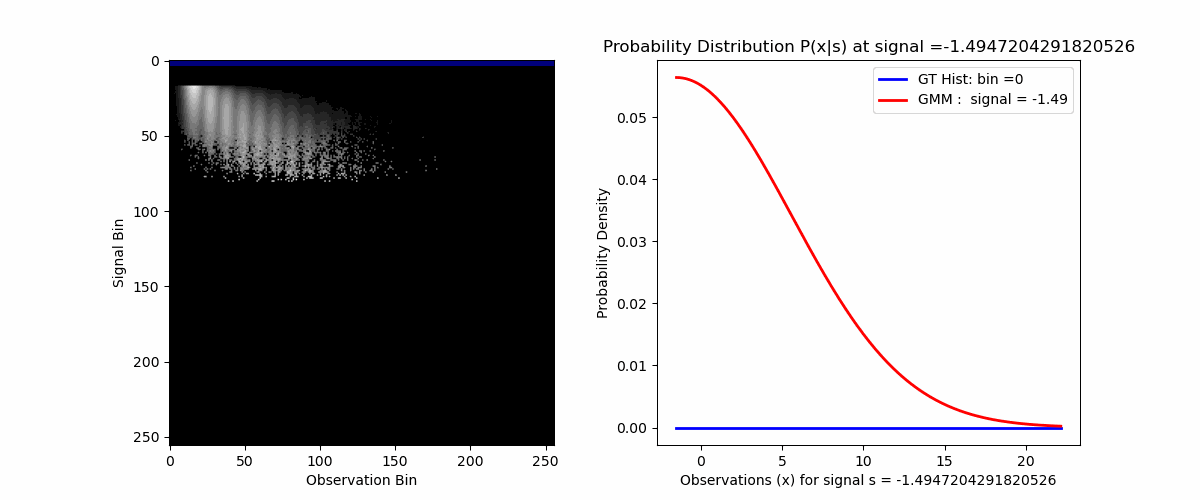

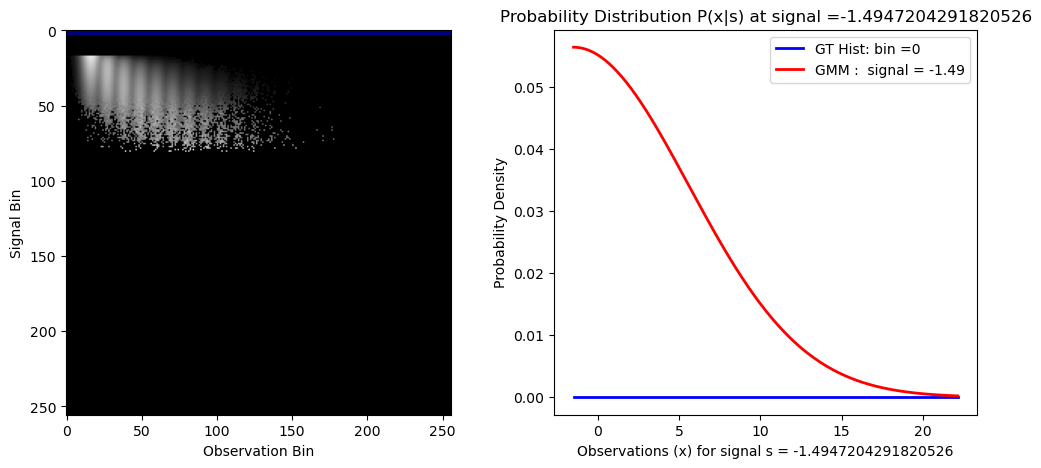

In [6]:
# Initialize figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Animation function
def animate(i):
    plotProbabilityDistribution(ax1, ax2, signalBinIndex=i, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=datamin, max_signal=datamax, n_bin=bins, device=device)
    return ax1, ax2

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=bins, interval=50, blit=False)

# Save the animation as a GIF
ani.save(os.path.join(out_folder, 'animation.gif'), writer='pillow')

# Display the GIF in a Jupyter Notebook (if you're using one)
from IPython.display import Image as IPImage
IPImage(filename=os.path.join(out_folder, 'animation.gif'))